# Chapter 4 AP

This assignment consists of two questions, one from the textbook and one written by the instructor. 

Each question is worth 20 points.

Requirements are similar to those for Chapter 12 AP.

## 1. Question 13 on page 196 of the textbook

Type your commands below. Be sure to organize your work clearly by using the Markdown.

## 13. This question should be answered using the Weekly data set, which is part of the ISLP package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots 
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, 
                                           QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

### a). Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

In [2]:
Weekly = load_data('Weekly') 
Weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


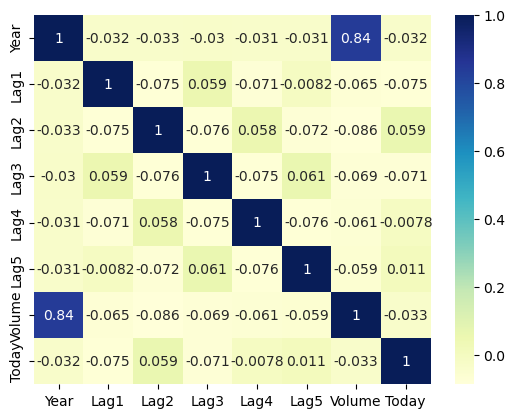

In [3]:
import seaborn as sns
corr_matrix = Weekly.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu");

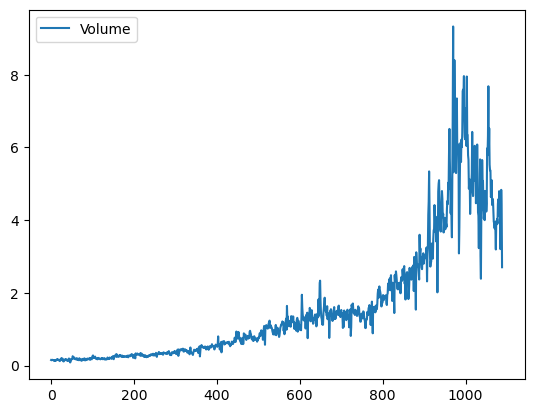

In [4]:
Weekly.plot(y='Volume');

In [5]:
allvars = Weekly.columns.drop(['Today', 'Direction', 'Year']) 
design = MS(allvars)
X = design.fit_transform(Weekly)
y = Weekly.Direction == 'Up'
glm = sm.GLM(y, X,
family=sm.families.Binomial()) 
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


<strong>Conclusion:</strong> The only variables that have any significant linear relation are <strong><u>volume</u></strong> and <strong><u>year</u></strong>. It does not appear that anything else is linearly related.

### b). Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [6]:
results.params

intercept    0.266864
Lag1        -0.041269
Lag2         0.058442
Lag3        -0.016061
Lag4        -0.027790
Lag5        -0.014472
Volume      -0.022742
dtype: float64

In [7]:
results.pvalues

intercept    0.001899
Lag1         0.118144
Lag2         0.029601
Lag3         0.546924
Lag4         0.293653
Lag5         0.583348
Volume       0.537675
dtype: float64

In [8]:
probs = results.predict() 
probs [:10]

array([0.60862494, 0.60103144, 0.58756995, 0.48164156, 0.61690129,
       0.56841902, 0.57860971, 0.51519724, 0.57151998, 0.55542873])

### c). Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [9]:
labels = np.array(['Down']*1089) 
#1250 is the size (n). Making an array of 1250 down, 
#if > 0.5 then it changes to up
labels[probs>0.5] = "Up"

In [10]:
confusion_table(labels, Weekly.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [11]:
(557+54)/1089, np.mean(labels == Weekly.Direction)

(0.5610651974288338, 0.5610651974288338)

In [12]:
557/(48+557), 54/(430+54)

(0.9206611570247933, 0.1115702479338843)

<strong>Conclusion:</strong> This confusion matrix and percentages are showing us that 56.1% of the daily movements have been correctly predicted. However, the confusion matrix shows that on days when logistic regression predicts an increase in the market, it also has a 92.06% accuracy rate, whereas days when logistic regression predicts an decrease in the market only has an 11.15% accuracy rate. This suggests a possible trading strategy of buying on days when the model predicts an increasing market, and avoiding trades on days when a decrease is predicted.

### d). Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [13]:
train = (Weekly.Year < 2009) 
Weekly_train = Weekly.loc[train] 
Weekly_test = Weekly.loc[~train] 
Weekly_test.shape

(104, 9)

In [14]:
X_train, X_test = X.loc[train], X.loc[~train] 
y_train, y_test = y.loc[train], y.loc[~train] 
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial()) 
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [15]:
D = Weekly.Direction
L_train, L_test = D.loc[train], D.loc[~train]

In [16]:
labels = np.array(['Down']*104) #313 = num of observations (rows) in train
labels[probs>0.5] = 'Up' 
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,31,44
Up,12,17


In [17]:
np.mean(labels == L_test), np.mean(labels != L_test)

(0.46153846153846156, 0.5384615384615384)

In [18]:
model = MS(['Lag2']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train] 
glm_train = sm.GLM(y_train,
                   X_train ,
                   family=sm.families.Binomial()) 
results = glm_train.fit()
probs = results.predict(exog=X_test) 
labels = np.array(['Down']*104) 
labels[probs>0.5] = 'Up' 
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [19]:
(9+56)/104

0.625

When spliting up the whole Weekly dataset into a training and test dataset, the model correctly predicted weekly trends at rate of 62.5%, which is a moderate improvement from the model that utilized the whole dataset.

In [20]:
newdata = pd.DataFrame({'Lag1':[1.2, 1.5], 
                        'Lag2':[1.1, -0.8]});
newX = model.transform(newdata) 
results.predict(newX)

0    0.566396
1    0.539115
dtype: float64

### e). Repeat (d) using LDA.

In [21]:
lda = LDA(store_covariance=True)

In [22]:
X_train, X_test = [M.drop(columns=['intercept']) 
                   for M in [X_train, X_test]]
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [23]:
lda.means_

array([[-0.03568254],
       [ 0.26036581]])

In [24]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [25]:
lda.priors_ #prior probability

array([0.44771574, 0.55228426])

In [26]:
lda.scalings_

array([[0.44141622]])

In [27]:
lda_pred = lda.predict(X_test)

In [28]:
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [29]:
(56+9)/104

0.625

<strong>Conclusion:</strong> These results are identical as Logistic Regression

### f). Repeat (d) using QDA

In [30]:
qda = QDA(store_covariance=True) 
qda.fit(X_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [31]:
qda.means_, qda.priors_

(array([[-0.03568254],
        [ 0.26036581]]),
 array([0.44771574, 0.55228426]))

In [32]:
qda.covariance_[0]

array([[4.83781758]])

In [33]:
qda_pred = qda.predict(X_test) 
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [34]:
(61+0)/104

0.5865384615384616

<strong>Conclusion:</strong> QDA provided an accuracy of 58.65% which is lower than the previous methods. We also see that it did not predict downward weekly trends, only upwards.

### g). Repeat (d) using KNN with K = 1.

In [35]:
knn1 = KNeighborsClassifier(n_neighbors=1) 
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test) 
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,21,30
Up,22,31


In [36]:
(31+21)/104

0.5

<strong>Conclusion:</strong> This is worse than all of the other methods, with a percentage of 50% you might as well guess or flip a coin to see if it would be a downward or upward trend.

### h). Which of these methods appears to provide the best results on this data?

<strong>Conclusion:</strong> It appears that both <strong><u>Logistic Regression</u></strong> and <strong><u>LDA</u></strong> have the highest accuracy 62.5%.

### i). Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. 
Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

## 2. Question written by the instructor 

In this assignment you are asked to perform classification using various classifiers on the iris data set; for a detailed description of the data, see https://archive.ics.uci.edu/dataset/53/iris.

### (1) First, load the data into Python using the following scripts.

In [37]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
iris = datasets.load_iris()

The features are stored in iris['data'] and the labels are in iris['target'].

### Afterwards, standardize the features and apply 2D PCA to the standardized data. Plot the first two principal components of the data, color coded by the true labels.


In [38]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [39]:
scaler = StandardScaler(with_std=True, with_mean=True)
iris_scaled = scaler.fit_transform(iris['data'])

In [40]:
pca = PCA()
scores = pca.fit_transform(iris_scaled)

In [41]:
pca.components_

array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [ 0.37741762,  0.92329566,  0.02449161,  0.06694199],
       [-0.71956635,  0.24438178,  0.14212637,  0.63427274],
       [-0.26128628,  0.12350962,  0.80144925, -0.52359713]])

Text(0, 0.5, 'PC2')

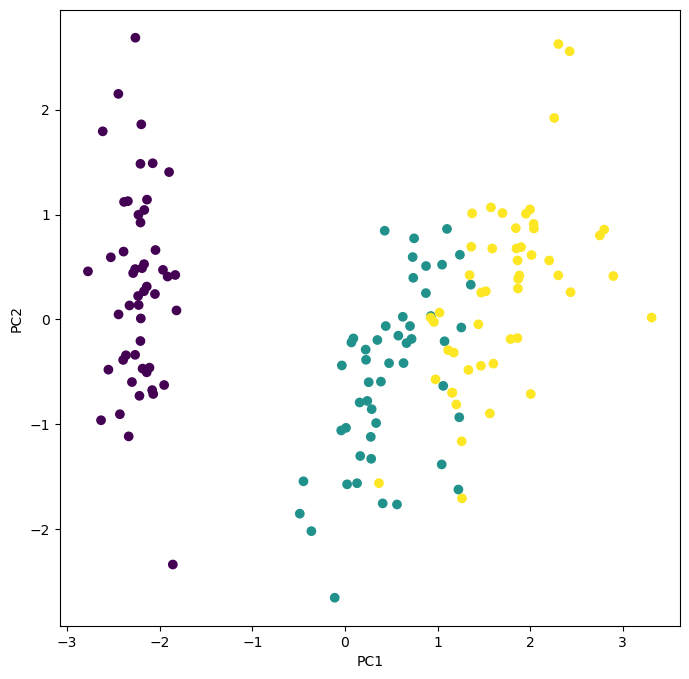

In [42]:
import matplotlib.pyplot as plt
i, j = 0, 1 # which components
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 
ax.scatter(scores[:,0], scores[:,1], c=iris['target']) 
ax.set_xlabel('PC%d' % (i+1)) 
ax.set_ylabel('PC%d' % (j+1))

# for k in range(pca.components_.shape[1]):
#     ax.arrow(0, 0, pca.components_[i,k], pca.components_[j,k]) 
#     ax.text(pca.components_[i,k], pca.components_[j,k], iris['target_names'][k])

### (2) Now focus on the two classes, 'versicolor' and 'virginica', and fit a binary logistic regression model. What is the training error? Plot also the decision boundary.


In [43]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

In [44]:
newScores = scores[50:,0]
newScores.shape

(100,)

In [45]:
X = newScores.reshape(-1,1)
y = iris.target

In [46]:
y = y[y != 0] #Exclude 0, which is Setosa
y = np.where(y == 1, 0, np.where(y == 2, 1, y)) # Flip 1's to 0 and 2's to 1
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

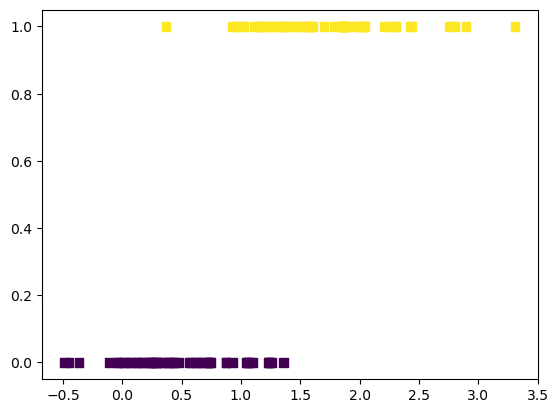

In [47]:
plt.scatter(X, y, c=y, marker='s');

In [49]:
LRmodel = linear_model.LogisticRegression(penalty=None).fit(X, y.ravel())
print(LRmodel.intercept_)  # location parameter (theta_0)
print(LRmodel.coef_)   # scale parameter (theta_1)

[-6.02278935]
[[5.51778201]]


In [50]:
prob = LRmodel.predict_proba(X)  # fitted probabilities [P(Y=0), P(Y=1)]
print(prob)

[[4.85854015e-01 5.14145985e-01]
 [8.79470858e-01 1.20529142e-01]
 [3.04774516e-01 6.95225484e-01]
 [9.77563774e-01 2.24362258e-02]
 [5.22124142e-01 4.77875858e-01]
 [9.79729251e-01 2.02707489e-02]
 [8.70298542e-01 1.29701458e-01]
 [9.99835384e-01 1.64616071e-04]
 [7.11530799e-01 2.88469201e-01]
 [9.97426065e-01 2.57393510e-03]
 [9.98682668e-01 1.31733226e-03]
 [9.73172633e-01 2.68273671e-02]
 [9.48884449e-01 5.11155514e-02]
 [8.86190274e-01 1.13809726e-01]
 [9.97988444e-01 2.01155563e-03]
 [7.67184906e-01 2.32815094e-01]
 [9.83539221e-01 1.64607790e-02]
 [9.94213993e-01 5.78600658e-03]
 [3.23658262e-01 6.76341738e-01]
 [9.94016858e-01 5.98314193e-03]
 [8.75709985e-01 1.24290015e-01]
 [9.67539757e-01 3.24602434e-02]
 [3.12783879e-01 6.87216121e-01]
 [9.26274081e-01 7.37259187e-02]
 [8.95262346e-01 1.04737654e-01]
 [7.68300188e-01 2.31699812e-01]
 [2.86927393e-01 7.13072607e-01]
 [1.86548660e-01 8.13451340e-01]
 [9.13296461e-01 8.67035387e-02]
 [9.98063486e-01 1.93651371e-03]
 [9.950385

In [51]:
pred = LRmodel.predict(X)  # prediction of labels
print(pred)

[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0]


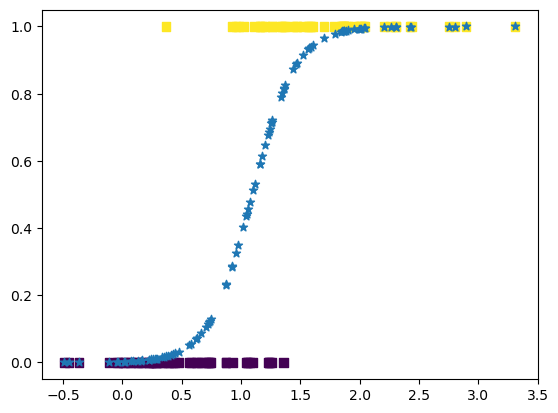

In [52]:
plt.scatter(X, y, c=y, marker='s');
plt.scatter(X,prob[:,1],marker='*');

#### LR – Decision Boundary:

In [53]:
y = np.logical_or(iris.target==1, iris.target==2)
x1o2 = scores[y, :2]
target = iris.target[y]
LRModel = linear_model.LogisticRegression(penalty=None).fit(x1o2, target)
LRpredict = LRModel.predict(x1o2)
confusion_table(LRpredict, target)

Truth,1,2
Predicted,,
1,43,5
2,7,45


In [54]:
print(np.mean(LRpredict == target), np.mean(LRpredict != target));

0.88 0.12


<strong>Training Error:</strong> The training error for binary logistic regression is 88% accuracy, which is ok but not the best.

In [55]:
newScoresX = scores[50:,0]
newScoresY = scores[50:,1]
newScoresX.shape, newScoresY.shape

((100,), (100,))

In [56]:
y = iris.target
y = y[y != 0] #Exclude 0, which is Seratosa
y = np.where(y == 1, 0, np.where(y == 2, 1, y)) # Flip 1's to 0 and 2's to 1
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [57]:
X = newScoresX.reshape(-1,2)
truelabels = y
y = newScoresY.reshape(-1,2)

In [58]:
X = np.concatenate((X, y), axis=0)

In [59]:
truelabels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

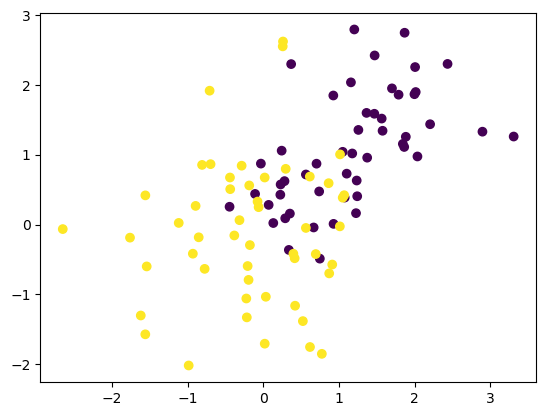

In [60]:
plt.scatter(x=X[:,0], y=X[:,1], c=truelabels);   # plot the data

In [61]:
LRmodel = linear_model.LogisticRegression(penalty=None).fit(X, truelabels.ravel())
LRprobs = LRmodel.predict_proba(X)  # fitted probxabilities

In [62]:
LRmodel.coef_

array([[-1.90902945, -0.86269382]])

In [63]:
LRmodel.intercept_

array([1.27142862])

In [64]:
np.sum(LRmodel.predict(X)-truelabels.ravel() != 0)

21

##### Decision Boundary:

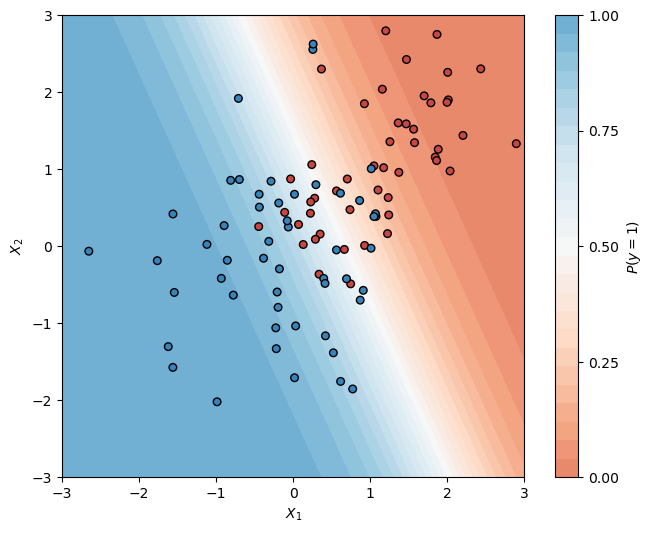

In [65]:
# Next, make a continuous grid of values and evaluate the probability of each (x, y) point in the grid:

xx, yy = np.mgrid[-3.5:3.5:.01, -3.5:3.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
LRprobs = LRmodel.predict_proba(grid)[:, 1].reshape(xx.shape)

# Now, plot the probability grid as a contour map and additionally show the test set samples on top of it:

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, LRprobs, 30, cmap="RdBu", vmin=-0.5, vmax=1.5)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[:,0], X[:,1], c=truelabels, s=30,
           cmap="RdBu", vmin=-0.25, vmax=1.25,
           edgecolor="black", linewidth=1);

ax.set(aspect="equal",
       xlim=(-3, 3), ylim=(-3, 3),
       xlabel="$X_1$", ylabel="$X_2$");

### (3) For the above two iris classes, fit two more models: LDA and QDA. What are their training error rates? Plot their decision boundaries together with the binary logistic regression model. Which model do you think is the most appropriate for these two classes? 

#### LDA:

In [66]:
LDAModel = lda.fit(X, truelabels.ravel())

np.sum(lda.predict(X)-truelabels.ravel() != 0)

21

In [67]:
y = np.logical_or(iris.target==1, iris.target==2)
x1o2 = scores[y, :2]
target = iris.target[y]
LDApredict = LDAModel.predict(x1o2)
print(np.mean(LDApredict == target), np.mean(LDApredict != target));

0.37 0.63


In [68]:
confusion_table(LDApredict, target)

Truth,0,1,2
Predicted,,,
0,0,13,43
1,0,37,7
2,0,0,0


#### QDA:

In [69]:
QDAModel = qda.fit(X, truelabels.ravel())

np.sum(qda.predict(X)-truelabels.ravel() != 0)

17

In [70]:
y = np.logical_or(iris.target==1, iris.target==2)
x1o2 = scores[y, :2]
target = iris.target[y]
QDApredict = QDAModel.predict(x1o2)
print(np.mean(QDApredict == target), np.mean(QDApredict != target));

0.37 0.63


In [71]:
confusion_table(QDApredict, target)

Truth,0,1,2
Predicted,,,
0,0,13,33
1,0,37,17
2,0,0,0


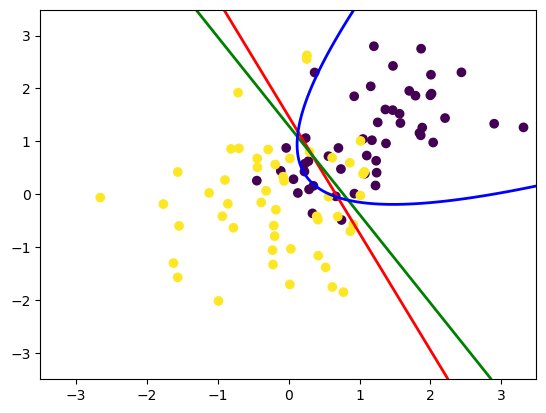

In [72]:
from matplotlib import colors

xx, yy = np.mgrid[-3.5:3.5:.01, -3.5:3.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]

Z_lda = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z_lda = Z_lda[:, 1].reshape(xx.shape)

Z_qda = qda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z_qda = Z_qda[:, 1].reshape(xx.shape)

# Z_gnb = GNB.predict_proba(np.c_[xx.ravel(), yy.ravel()])
# Z_gnb = Z_gnb[:, 1].reshape(xx.shape)

plt.scatter(x=X[:,0], y=X[:,1], c=truelabels);   # plot the data

plt.contour(xx, yy, LRprobs, [0.5], linewidths=2.0, colors="red")  # logistic
plt.contour(xx, yy, Z_lda, [0.5], linewidths=2.0, colors="green")  # LDA
plt.contour(xx, yy, Z_qda, [0.5], linewidths=2.0, colors="blue")   # QDA
# plt.contour(xx, yy, Z_gnb, [0.5], linewidths=2.0, colors="purple") # GaussianNB
#plt.legend(['LR','LDA','QDA', 'GNB'])

<strong>Conclusion:</strong> The training error for all of these are pretty similar, but since there are only 2 classes, I would be more inclined to go with LDA, with QDA close behind. In this model QDA doesn't really exclude more points than LDA, otherwise that would be a deciding factor.

### (4) Apply the one-versus-rest multiclass logistic regression classifier to all three classes of the iris data (using the two dimensional principal components obtained above). Display the confusion matrix and comment on it. What is the overall training error?

In [73]:
LRModel = linear_model.LogisticRegression(penalty=None, multi_class='ovr').fit(scores, iris.target)
LRpredict = LRModel.predict(scores)
confusion_table(LRpredict, iris.target)

Truth,0,1,2
Predicted,,,
0,50,0,0
1,0,48,1
2,0,2,49


In [74]:
print(np.mean(LRpredict == iris.target), np.mean(LRpredict != iris.target));

0.98 0.02


<strong>OVR LR Conclusion:</strong> This is a very impressive model, with a 98% success rate (2% training error). This also begs the questions as to whether or no we are overfitting, which could be answered if we split our data into Training and Test data, or have another dataset to test this on.

### (5)  Repeat (4) with the multinomial logistic regression classifier instead. How does it compare with the one-versus-rest extension?

In [75]:
LRModel = linear_model.LogisticRegression(penalty=None, multi_class='multinomial').fit(scores, iris.target)
LRpredict = LRModel.predict(scores)
confusion_table(LRpredict, iris.target)

Truth,0,1,2
Predicted,,,
0,50,0,0
1,0,49,1
2,0,1,49


In [76]:
print(np.mean(LRpredict == iris.target), np.mean(LRpredict != iris.target));

0.9866666666666667 0.013333333333333334


<strong>Multinomial LR Conclusion:</strong> Again, a very impressive model, with a 98.867% success rate (<2% training error). This also begs the questions as to whether or no we are overfitting, but it is still impressive nonetheless. This could mean that there is a pretty clean split that is apparent when fitting 3 classes.

### (6) Repeat (4) with each of the LDA and QDA classifiers. How do they compare with logistic regression in terms of training error? Which one will generalize the best to test data (when they become available)?

#### LDA :

In [77]:
LDAModel = lda.fit(scores, iris.target)
LDApredict = LDAModel.predict(scores)
confusion_table(LDApredict, iris.target)

Truth,0,1,2
Predicted,,,
0,50,0,0
1,0,48,1
2,0,2,49


In [78]:
print(np.mean(LDApredict == iris.target), np.mean(LDApredict != iris.target));

0.98 0.02


<strong>LDA Conclusion:</strong> This performed the same as OVR LR, which is already a very impressive model, with a 98% success rate (2% training error). LDA is more trustworthy, but without test data we should not jump to conclusions.

#### QDA:

In [79]:
QDAModel = qda.fit(scores, iris.target)
QDApredict = QDAModel.predict(scores)
confusion_table(QDApredict, iris.target)

Truth,0,1,2
Predicted,,,
0,50,0,0
1,0,48,1
2,0,2,49


In [80]:
print(np.mean(QDApredict == iris.target), np.mean(QDApredict != iris.target));

0.98 0.02


<strong>QDA Conclusion:</strong> This performed the same as LDA and OVR LR, which is, again, a very impressive model, with a 98% success rate (2% training error). I'm prone to trusting QDA at this point and the other models, as multiple of them came up with the same result.